In [1]:
import numpy as np
from scipy import stats
import time
from tqdm import tqdm
import pickle

# Parameters
p = 4  # Number of x covariates (including intercept)
d = 1  # Dimension of z
rho = 0.5  # Probability for Bernoulli
sigma = 1
delta_0 = 0.2  # True value of delta
xi = delta_0 / sigma




import numpy as np
from scipy.stats import ncf, f

def power_n(n, delta, sigma, rho, alpha, p=4, d=1):
    """Compute power of F-test for sample size n."""
    nu = n - p - d
    lam = n * delta**2 * rho * (1 - rho) / sigma**2
    f_crit = f.ppf(1 - alpha, dfn=d, dfd=nu)
    return 1 - ncf.cdf(f_crit, dfn=d, dfd=nu, nc=lam)

def required_n_doubling(delta, sigma, rho, alpha, target_power,
                        p=4, d=1, n_start=None):
    """
    Find minimal n via doubling then bisection.
    
    1. Start at n = p+d+1 (or provided n_start).
    2. Double n until power(n) >= target_power.
    3. Bisection search in [n/2, n] for the exact minimal n.
    """
    if n_start is None:
        n_start = p + d + 1
    
    # If starting n already suffices, return it
    if power_n(n_start, delta, sigma, rho, alpha, p, d) >= target_power:
        return n_start, power_n(n_start, delta, sigma, rho, alpha, p, d)
    
    # Doubling phase
    low = n_start
    high = low * 2
    while power_n(high, delta, sigma, rho, alpha, p, d) < target_power:
        low = high
        high *= 2
    
    # Bisection phase
    while low < high:
        mid = (low + high) // 2
        if power_n(mid, delta, sigma, rho, alpha, p, d) < target_power:
            low = mid + 1
        else:
            high = mid
    
    return low, power_n(low, delta, sigma, rho, alpha, p, d)


alpha = 0.01
beta = 0.05
power = 1 - beta

n_req, pow_achieved = required_n_doubling(delta_0, sigma, rho, alpha, power)
print(f"Fixed Sample Size n: {n_req}, Achieved power: {pow_achieved:.4f}")
n = n_req
nu_n = n - p - d

Fixed Sample Size n: 1785, Achieved power: 0.9500


Optimal log(g): 5.01920840, Optimal g: 1.51291494e+02, Minimum log(R): 2.54933456, Success: True


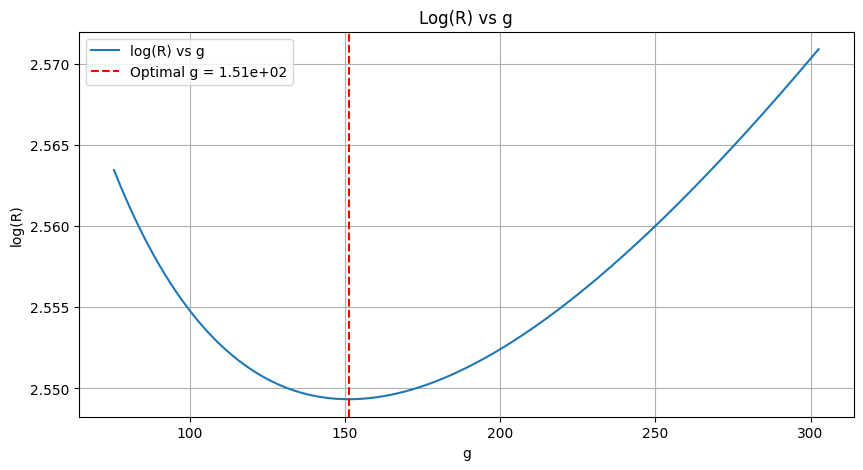

In [2]:
import numpy as np
from scipy import stats, optimize
import math
import matplotlib.pyplot as plt

def log_R(log_g, n, alpha, d=1, nu_n=None):
    # Convert to working variables
    g = np.exp(log_g)
    
    # Compute key quantities in log space
    log_alpha_squared = 2 * np.log(alpha)
    log_g_d = d * log_g
    log_n_plus_g_d = d * np.log(n + g)
    
    # log(α²g^d/(n+g)^d)
    log_ratio = log_alpha_squared + log_g_d - log_n_plus_g_d
    
    # log(powered_term) = log_ratio / (ν_n + d)
    exponent = 1.0 / (nu_n + d)
    log_powered_term = exponent * log_ratio
    
    # Check if powered_term >= 1 (which makes R undefined)
    if log_powered_term >= 0:
        return np.inf
    
    # For numerator: (ν_n/d) * (1 - powered_term)
    # log(1 - exp(x)) for x < 0
    powered_term = np.exp(log_powered_term)
    one_minus_powered = 1.0 - powered_term
    
    if one_minus_powered <= 0:
        return np.inf
    
    log_numerator_coeff = np.log(nu_n / d)
    log_one_minus_powered = np.log(one_minus_powered)
    log_numerator = log_numerator_coeff + log_one_minus_powered
    
    # For denominator: powered_term - g/(n+g)
    g_ratio = g / (n + g)
    denominator_val = powered_term - g_ratio
    
    if denominator_val <= 0:
        return np.inf
    
    log_denominator = np.log(denominator_val)
    
    # Final log(R)
    log_R = log_numerator - log_denominator
    
    return log_R


# Define objective function
def objective_function(log_g):
    return log_R(log_g, n, alpha, nu_n = nu_n)


result = optimize.minimize(objective_function, np.log(n))
g_width_optimizer = np.exp(result.x[0])
print(f"Optimal log(g): {result.x[0]:.8f}, Optimal g: {g_width_optimizer:.8e}, Minimum log(R): {result.fun:.8f}, Success: {result.success}")

# Plot the function
g_plot = np.linspace(g_width_optimizer*0.5, g_width_optimizer*2, 1000)
log_g_plot = np.log(g_plot)
log_R_plot = [objective_function(np.log(g)) for g in g_plot]
plt.figure(figsize=(10, 5))
plt.plot(g_plot, log_R_plot, label='log(R) vs g')
plt.axvline(g_width_optimizer, color='red', linestyle='--', label=f'Optimal g = {g_width_optimizer:.2e}')
plt.xlabel('g')
plt.ylabel('log(R)')
plt.title('Log(R) vs g')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
optimal_phi = 1/xi**2
g_growth_optimizer = optimal_phi / (rho * (1 - rho))
print("Sample Size:", n)
print(f"Optimal g growth: {g_growth_optimizer:.8f}")
print(f"g_width_optimizer: {g_width_optimizer:.8f}")
print(f"Optimal phi: {optimal_phi:.8f}")
g_growth_optimizer * rho * (1 - rho)

Sample Size: 1785
Optimal g growth: 100.00000000
g_width_optimizer: 151.29149360
Optimal phi: 25.00000000


24.999999999999996

In [4]:
import numpy as np
from scipy.stats import f
from tqdm import tqdm
import time

n_simulations = 10000  # Number of simulations to run
# Function to generate data according to the model


def generate_data(n, seed = 1, Bayesian = False):
    np.random.seed(seed)  # Set seed for reproducibility
    # Generate correlation matrix Sigma with Sigma_ij = 0.8^|i-j|
    Sigma = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            Sigma[i, j] = 0.8 ** abs(i - j)
    
    # Generate x_i ~ N(0, Sigma)
    X = np.random.multivariate_normal(np.zeros(3), Sigma, n)
    
    # Generate z_i ~ Bernoulli(rho)
    Z = np.random.binomial(1, rho, size=(n, 1)) - rho
    
    # Generate epsilon_i ~ t_5(0, 1.5)
    epsilon = sigma * np.random.normal(size=n)
    
    # Compute y according to the model
    y = 1 - 0 * X[:, 0] - 1 * X[:, 1] + 2 * X[:, 2] + Z.flatten() * delta_0 + epsilon
    
    # Create design matrix W = [1, x_i1^2, sin(x_i2), |x_i3|, z_i]
    W = np.column_stack((
        np.ones(n),       
        X[:, 0],       
        X[:, 1],  
        X[:, 2],  
        Z                 
    ))
    
    return W, y

# Compute OLS estimates at each step with rank-1 updates
def compute_sequential_estimates(W_all, y_all):
    n_samples = len(y_all)
    n_min = p + d + 5  # Minimum sample size to start with
    
    # Arrays to store results
    delta_hats = np.full(n_samples, np.nan)  # Store as NaN until computable
    s_squared_vals = np.full(n_samples, np.nan)
    
    # Matrix for storing (Z'Z)^-1 at each step for F statistic calculation
    ZtZ_invs = np.full((n_samples, d, d), np.nan)
    
    # Indicator of when estimates become valid
    valid_indices = []
    
    # Precompute all outer products of W_all rows - this is a key optimization
    # This will be a 3D array of shape (n_samples, p+d, p+d)
    W_outer_products = np.zeros((n_samples, W_all.shape[1], W_all.shape[1]))
    for i in range(n_samples):
        W_outer_products[i] = np.outer(W_all[i], W_all[i])
    
    # Find the minimum n where W'W is invertible
    n_init = n_min
    invertible = False
    
    while n_init <= n_samples and not invertible:
        W_init = W_all[:n_init, :]
        WtW = W_init.T @ W_init
        
        # Check if matrix is invertible
        if np.linalg.matrix_rank(WtW) == WtW.shape[0]:
            invertible = True
        else:
            n_init += 1

    W_init = W_all[:n_init, :]
    y_init = y_all[:n_init]
    WtW = W_init.T @ W_init
    Wty = W_init.T @ y_init
    WtW_inv = np.linalg.inv(WtW)
    gamma_hat = WtW_inv @ Wty
    
    # Extract delta_hat
    delta_hat = gamma_hat[p:p+d]
    
    # Compute s^2
    y_hat = W_init @ gamma_hat
    residuals = y_init - y_hat
    RSS = residuals.T @ residuals
    s_squared = RSS / (n_init - p - d)
    
    # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
    # This is the lower right d×d submatrix of WtW_inv
    ZtZ_inv = WtW_inv[p:p+d, p:p+d]
    
    # Store initial results
    delta_hats[n_init-1] = delta_hat[0]
    s_squared_vals[n_init-1] = s_squared
    ZtZ_invs[n_init-1, :, :] = ZtZ_inv
    valid_indices.append(n_init-1)

    S_yy = y_init.T @ y_init
    
    # Now use rank-1 updates for subsequent observations
    for n in range(n_init+1, n_samples+1):
        # Get new observation
        w_new = W_all[n-1, :]
        y_new = y_all[n-1]
        
        # Sherman-Morrison formula for rank-1 update of inverse
        denom = 1 + w_new @ WtW_inv @ w_new

        # Update WtW_inv using Sherman-Morrison with precomputed outer product
        WtW_inv_update = WtW_inv - (WtW_inv @ W_outer_products[n-1] @ WtW_inv) / denom
        WtW_inv = WtW_inv_update
        
        # Update WtW with precomputed outer product
        WtW = WtW + W_outer_products[n-1]
        
        # Update Wty
        S_yy += y_new ** 2
        Wty = Wty + w_new * y_new
    
        # Compute gamma_hat with updated matrices
        gamma_hat = WtW_inv @ Wty
        
        # Extract delta_hat
        delta_hat = gamma_hat[p:p+d]
    

        SSR       = gamma_hat.dot(Wty)
        RSS       = S_yy - SSR
        s_squared = RSS / (n - p - d)



        
        # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
        ZtZ_inv = WtW_inv[p:p+d, p:p+d]
        
        # Store results
        delta_hats[n-1] = delta_hat[0]
        s_squared_vals[n-1] = s_squared
        ZtZ_invs[n-1, :, :] = ZtZ_inv
        valid_indices.append(n-1)
    
    return delta_hats, s_squared_vals, ZtZ_invs, valid_indices


def convert_to_F(delta_hat, s_squared, ZtZ_inv):
    F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)
    return F_n

def convert_to_G(F_n, n, g):
    nu_n = n - p - d
    if nu_n > 1:
        factor1 = (g / (g + n)) ** (d / 2)
        factor2 = (1 + (g / (g + n)) * (d / nu_n) * F_n) / (1 + (d / nu_n) * F_n)
        factor2 = factor2 ** (-(nu_n + d) / 2)
        G_n = factor1 * factor2
        return G_n
    else:
        return 1

In [5]:
f_crit = f.ppf(1 - alpha, dfn=1, dfd=n - p - d)

G_width_stopping_times = []
G_growth_stopping_times = []
classical_rejection = []
n_total = 10000  # Total number of observations



for i in range(n_simulations):
    #if i % 100 == 0:
    #    print(f"Simulation {i} of {n_simulations}")
    W, y = generate_data(n_total, seed = i, Bayesian=False)
    delta_hats, s_squared_vals, ZtZ_invs, valid_indices = compute_sequential_estimates(W, y)
    F = [convert_to_F(delta_hat, s_squared, ZtZ_inv) for delta_hat, s_squared, ZtZ_inv in zip(delta_hats, s_squared_vals, ZtZ_invs)]
    G_width = np.array([convert_to_G(F_n, n, g_width_optimizer) for n, F_n in enumerate(F, start=1)])
    G_growth = np.array([convert_to_G(F_n, n, g_growth_optimizer) for n, F_n in enumerate(F, start=1)])

    # using numpy find first index G_width > 0.05
    first_index_width = np.argmax(G_width > 1/alpha)
    G_width_stopping_times.append(first_index_width if first_index_width > 0 else np.nan)
    first_index_growth = np.argmax(G_growth > 1/alpha) 
    G_growth_stopping_times.append(first_index_growth if first_index_growth > 0 else np.nan)
    classical_rejection.append(F[n_req - 1] > f_crit)

G_width_stopping_times = np.sort(G_width_stopping_times)
G_growth_stopping_times = np.sort(G_growth_stopping_times)

with open('power_0.2.pkl', 'wb') as file:
    # Serialize and write G_width_stopping_times to the file
    pickle.dump(G_width_stopping_times, file)
    # Serialize and write G_growth_stopping_times to the file
    pickle.dump(G_growth_stopping_times, file)
    # Serialize and write classical_rejection to the file
    pickle.dump(classical_rejection, file)

/tmp/ipykernel_2844972/3458715989.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)


In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('power_0.2.pkl', 'rb') as file:
    # Deserialize and load G_width_stopping_times from the file
    G_width_stopping_times = pickle.load(file)
    # Deserialize and load G_growth_stopping_times from the file
    G_growth_stopping_times = pickle.load(file)
    # Deserialize and load classical_rejection from the file
    classical_rejection = pickle.load(file)

G_width_ecdf = np.arange(1, len(G_width_stopping_times) + 1) / len(G_width_stopping_times)
G_growth_ecdf = np.arange(1, len(G_growth_stopping_times) + 1) / len(G_growth_stopping_times)
print("Average Stopping Time G-Width: {}".format(np.mean(G_width_stopping_times)))
print("Max Stopping Time G-Width: {}".format(np.max(G_width_stopping_times)))
print("Average Stopping Time G-Growth: {}".format(np.mean(G_growth_stopping_times)))
print("Max Stopping Time G-Growth: {}".format(np.max(G_growth_stopping_times)))

Average Stopping Time G-Width: 1236.0364
Max Stopping Time G-Width: 5263
Average Stopping Time G-Growth: 1214.4668
Max Stopping Time G-Growth: 5314


/tmp/ipykernel_2844972/2093914447.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1').colors


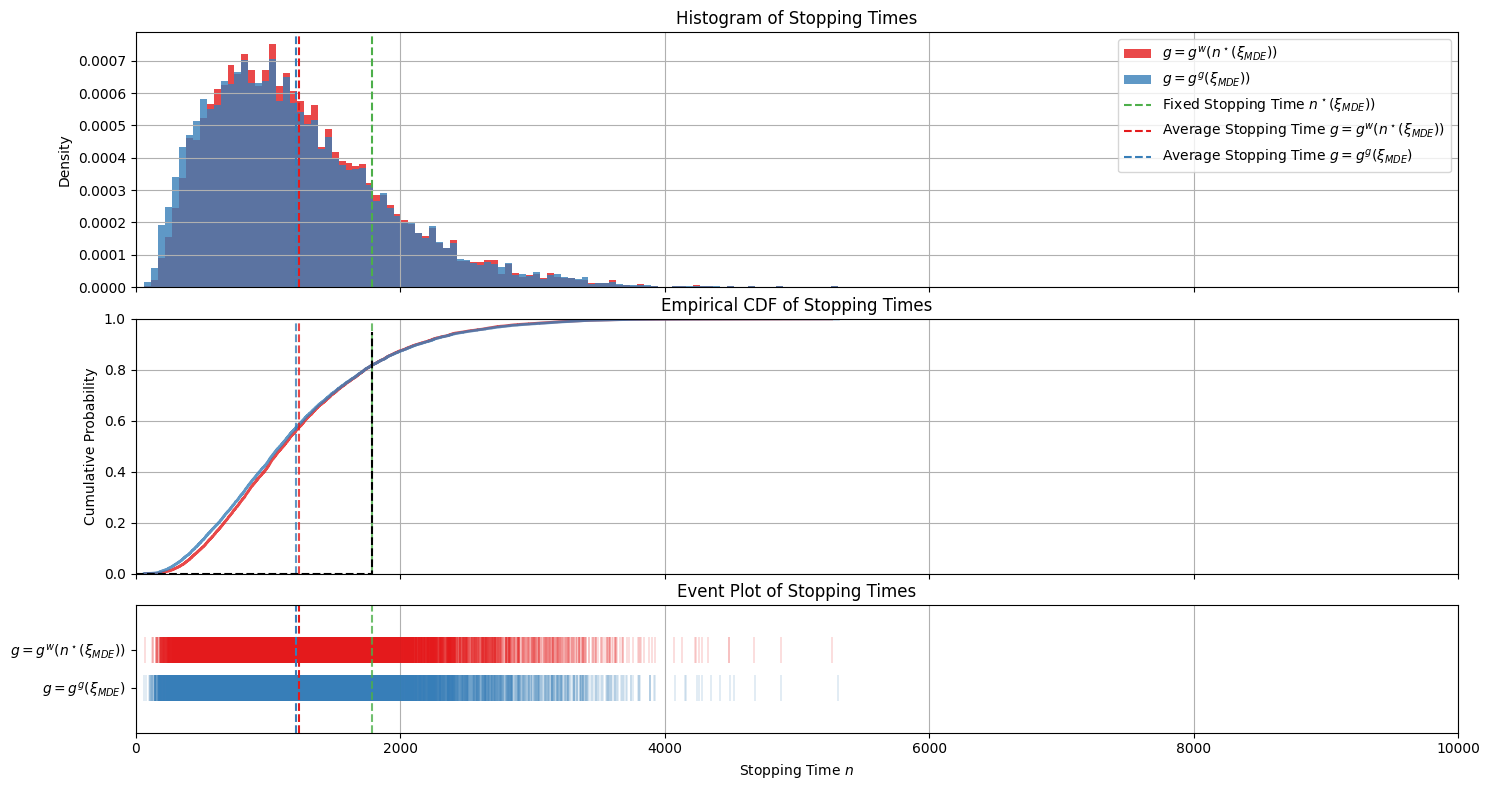

In [7]:


# Calculate optimal bins based on both datasets
all_data = np.concatenate([G_width_stopping_times, G_growth_stopping_times])
counts, bins = np.histogram([d for d in all_data if not np.isnan(d)], bins=100)

colors = plt.cm.get_cmap('Set1').colors
width_color = colors[0]  # Second color in Set1
growth_color = colors[1]  # Third color in Set1
fixed_color = colors[2]  # Fourth color in Set1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), height_ratios=[2, 2, 1], sharex=True)

# Top pane: Histogram
if delta_0 == 0.0:
    density = False
else:
    density = True
ax1.hist(G_width_stopping_times, bins=bins, alpha=0.8, label='$g = g^w(n^\\star(\\xi_{MDE}))$', density=density, color = width_color)
ax1.hist(G_growth_stopping_times, bins=bins, alpha=0.8, label='$g = g^g(\\xi_{MDE}))$', density=density, color = growth_color)
ax1.axvline(x=n_req,  linestyle='--', label='Fixed Stopping Time $n^\\star(\\xi_{MDE}))$', color=fixed_color)
ax1.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='Average Stopping Time $g = g^w(n^\\star(\\xi_{MDE}))$', color = width_color)
ax1.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='Average Stopping Time $g = g^g(\\xi_{MDE})$', color = growth_color)
ax1.grid()
ax1.legend()
if delta_0 == 0.0:
    ax1.set_ylabel('Counts')
else:
    ax1.set_ylabel('Density')
ax1.set_title('Histogram of Stopping Times')


ax2.plot(G_width_stopping_times, G_width_ecdf, alpha=0.8, linewidth=2, label='$g = g^w(n^\\star(\\xi_{MDE}))$', color=width_color)
ax2.plot(G_growth_stopping_times, G_growth_ecdf, alpha=0.8, linewidth=2, label='$g = g^g(\\xi_{MDE})$', color=growth_color)
ax2.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax2.axvline(x=np.mean(G_width_stopping_times), linestyle='--', alpha=0.8, color=width_color)
ax2.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', alpha=0.8, color=growth_color)
ax2.grid()
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Empirical CDF of Stopping Times')
ax2.step([0, n_req], [0, np.mean(classical_rejection)], where='post',
         linestyle='--', color='black', label='Classical Rejection Rate')
if delta_0 == 0.0:
    ax2.set_ylim(0,0.02)
    ax2.axhline(y=alpha, linestyle='--', color='black', label='α = 0.01')
    ax2.legend(loc='upper right')
else:
    ax2.set_ylim(0, 1)

# Bottom pane: Rugplot
ax3.eventplot(G_width_stopping_times, orientation='horizontal', lineoffsets=0.3, linelengths=0.4, 
              colors=width_color, alpha=1, linewidths=0.2)
ax3.eventplot(G_growth_stopping_times, orientation='horizontal', lineoffsets=-0.3, linelengths=0.4, 
              colors=growth_color, alpha=1, linewidths=0.2)
ax3.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax3.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='$g = g^w(n^\\star(\\xi_{MDE}))$ mean', color = width_color)
ax3.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='$g = g^g(\\xi_{MDE})$', color = growth_color)



# Clean up rugplot pane
ax3.set_ylim(-1, 1)
ax3.set_yticks([0.3, -0.3])
ax3.set_yticklabels(['$g = g^w(n^\\star(\\xi_{MDE}))$', '$g = g^g(\\xi_{MDE})$'])
ax3.set_title('Event Plot of Stopping Times')
ax3.set_xlabel('Stopping Time $n$')
ax3.grid(axis='x')

plt.xlim(0, n_total)
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)  # Small space between subplots
plt.savefig('stopping_times_xi_0.2.png', dpi=300, bbox_inches='tight')
plt.show()

# $\xi = 2\xi_{MDE}$

In [8]:
delta_0 = 0.4  # True value of delta
xi = delta_0 / sigma

In [9]:
f_crit = f.ppf(1 - alpha, dfn=1, dfd=n - p - d)

G_width_stopping_times = []
G_growth_stopping_times = []
classical_rejection = []



for i in range(n_simulations):
    #if i % 100 == 0:
    #    print(f"Simulation {i} of {n_simulations}")
    W, y = generate_data(n_total, seed = i, Bayesian=False)
    delta_hats, s_squared_vals, ZtZ_invs, valid_indices = compute_sequential_estimates(W, y)
    F = [convert_to_F(delta_hat, s_squared, ZtZ_inv) for delta_hat, s_squared, ZtZ_inv in zip(delta_hats, s_squared_vals, ZtZ_invs)]
    G_width = np.array([convert_to_G(F_n, n, g_width_optimizer) for n, F_n in enumerate(F, start=1)])
    G_growth = np.array([convert_to_G(F_n, n, g_growth_optimizer) for n, F_n in enumerate(F, start=1)])

    # using numpy find first index G_width > 0.05
    first_index_width = np.argmax(G_width > 1/alpha)
    G_width_stopping_times.append(first_index_width if first_index_width > 0 else np.nan)
    first_index_growth = np.argmax(G_growth > 1/alpha) 
    G_growth_stopping_times.append(first_index_growth if first_index_growth > 0 else np.nan)
    classical_rejection.append(F[n_req - 1] > f_crit)

G_width_stopping_times = np.sort(G_width_stopping_times)
G_growth_stopping_times = np.sort(G_growth_stopping_times)

with open('power_0.4.pkl', 'wb') as file:
    # Serialize and write G_width_stopping_times to the file
    pickle.dump(G_width_stopping_times, file)
    # Serialize and write G_growth_stopping_times to the file
    pickle.dump(G_growth_stopping_times, file)
    # Serialize and write classical_rejection to the file
    pickle.dump(classical_rejection, file)

/tmp/ipykernel_2844972/3458715989.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)


In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('power_0.4.pkl', 'rb') as file:
    # Deserialize and load G_width_stopping_times from the file
    G_width_stopping_times = pickle.load(file)
    # Deserialize and load G_growth_stopping_times from the file
    G_growth_stopping_times = pickle.load(file)
    # Deserialize and load classical_rejection from the file
    classical_rejection = pickle.load(file)



G_width_ecdf = np.arange(1, len(G_width_stopping_times) + 1) / len(G_width_stopping_times)
G_growth_ecdf = np.arange(1, len(G_growth_stopping_times) + 1) / len(G_growth_stopping_times)
print("Average Stopping Time G-Width: {}".format(np.mean(G_width_stopping_times)))
print("Max Stopping Time G-Width: {}".format(np.max(G_width_stopping_times)))
print("Average Stopping Time G-Growth: {}".format(np.mean(G_growth_stopping_times)))
print("Max Stopping Time G-Growth: {}".format(np.max(G_growth_stopping_times)))

Average Stopping Time G-Width: 376.0612
Max Stopping Time G-Width: 1290
Average Stopping Time G-Growth: 350.3716
Max Stopping Time G-Growth: 1287


/tmp/ipykernel_2844972/3229262790.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1').colors


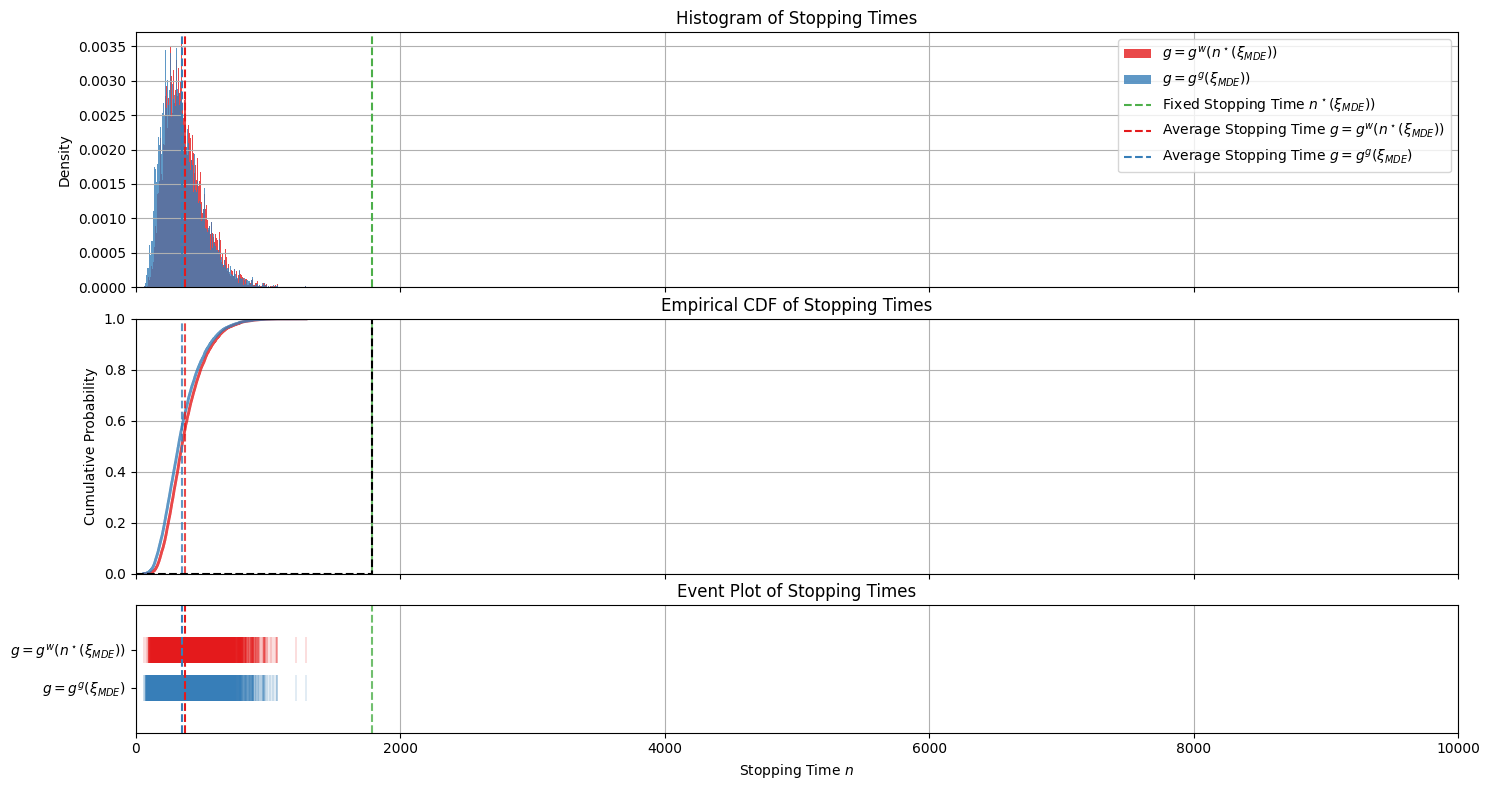

In [11]:
# Calculate optimal bins based on both datasets
all_data = np.concatenate([G_width_stopping_times, G_growth_stopping_times])
counts, bins = np.histogram([d for d in all_data if not np.isnan(d)], bins=200)

colors = plt.cm.get_cmap('Set1').colors
width_color = colors[0]  # Second color in Set1
growth_color = colors[1]  # Third color in Set1
fixed_color = colors[2]  # Fourth color in Set1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), height_ratios=[2, 2, 1], sharex=True)

# Top pane: Histogram
if delta_0 == 0.0:
    density = False
else:
    density = True
ax1.hist(G_width_stopping_times, bins=bins, alpha=0.8, label='$g = g^w(n^\\star(\\xi_{MDE}))$', density=density, color = width_color)
ax1.hist(G_growth_stopping_times, bins=bins, alpha=0.8, label='$g = g^g(\\xi_{MDE}))$', density=density, color = growth_color)
ax1.axvline(x=n_req,  linestyle='--', label='Fixed Stopping Time $n^\\star(\\xi_{MDE}))$', color=fixed_color)
ax1.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='Average Stopping Time $g = g^w(n^\\star(\\xi_{MDE}))$', color = width_color)
ax1.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='Average Stopping Time $g = g^g(\\xi_{MDE})$', color = growth_color)
ax1.grid()
ax1.legend()
if delta_0 == 0.0:
    ax1.set_ylabel('Counts')
else:
    ax1.set_ylabel('Density')
ax1.set_title('Histogram of Stopping Times')


ax2.plot(G_width_stopping_times, G_width_ecdf, alpha=0.8, linewidth=2, label='$g = g^w(n^\\star(\\xi_{MDE}))$', color=width_color)
ax2.plot(G_growth_stopping_times, G_growth_ecdf, alpha=0.8, linewidth=2, label='$g = g^g(\\xi_{MDE})$', color=growth_color)
ax2.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax2.axvline(x=np.mean(G_width_stopping_times), linestyle='--', alpha=0.8, color=width_color)
ax2.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', alpha=0.8, color=growth_color)
ax2.grid()
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Empirical CDF of Stopping Times')
ax2.step([0, n_req], [0, np.mean(classical_rejection)], where='post',
         linestyle='--', color='black', label='Classical Rejection Rate')
if delta_0 == 0.0:
    ax2.set_ylim(0,0.02)
    ax2.axhline(y=alpha, linestyle='--', color='black', label='α = 0.01')
    ax2.legend(loc='upper right')
else:
    ax2.set_ylim(0, 1)

# Bottom pane: Rugplot
ax3.eventplot(G_width_stopping_times, orientation='horizontal', lineoffsets=0.3, linelengths=0.4, 
              colors=width_color, alpha=1, linewidths=0.2)
ax3.eventplot(G_growth_stopping_times, orientation='horizontal', lineoffsets=-0.3, linelengths=0.4, 
              colors=growth_color, alpha=1, linewidths=0.2)
ax3.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax3.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='$g = g^w(n^\\star(\\xi_{MDE}))$ mean', color = width_color)
ax3.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='$g = g^g(\\xi_{MDE})$', color = growth_color)



# Clean up rugplot pane
ax3.set_ylim(-1, 1)
ax3.set_yticks([0.3, -0.3])
ax3.set_yticklabels(['$g = g^w(n^\\star(\\xi_{MDE}))$', '$g = g^g(\\xi_{MDE})$'])
ax3.set_title('Event Plot of Stopping Times')
ax3.set_xlabel('Stopping Time $n$')
ax3.grid(axis='x')

plt.xlim(0, n_total)
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)  # Small space between subplots
plt.savefig('stopping_times_xi_0.4.png', dpi=300, bbox_inches='tight')
plt.show()

# $\xi = 0$

In [12]:
delta_0 = 0.0  # True value of delta
xi = delta_0 / sigma

In [13]:
f_crit = f.ppf(1 - alpha, dfn=1, dfd=n - p - d)

G_width_stopping_times = []
G_growth_stopping_times = []
classical_rejection = []



for i in range(n_simulations):
    #if i % 100 == 0:
    #    print(f"Simulation {i} of {n_simulations}")
    W, y = generate_data(n_total, seed = i, Bayesian=False)
    delta_hats, s_squared_vals, ZtZ_invs, valid_indices = compute_sequential_estimates(W, y)
    F = [convert_to_F(delta_hat, s_squared, ZtZ_inv) for delta_hat, s_squared, ZtZ_inv in zip(delta_hats, s_squared_vals, ZtZ_invs)]
    G_width = np.array([convert_to_G(F_n, n, g_width_optimizer) for n, F_n in enumerate(F, start=1)])
    G_growth = np.array([convert_to_G(F_n, n, g_growth_optimizer) for n, F_n in enumerate(F, start=1)])

    # using numpy find first index G_width > 0.05
    first_index_width = np.argmax(G_width > 1/alpha)
    G_width_stopping_times.append(first_index_width if first_index_width > 0 else np.nan)
    first_index_growth = np.argmax(G_growth > 1/alpha) 
    G_growth_stopping_times.append(first_index_growth if first_index_growth > 0 else np.nan)
    classical_rejection.append(F[n_req - 1] > f_crit)

G_width_stopping_times = np.sort(G_width_stopping_times)
G_growth_stopping_times = np.sort(G_growth_stopping_times)

with open('power_0.pkl', 'wb') as file:
    # Serialize and write G_width_stopping_times to the file
    pickle.dump(G_width_stopping_times, file)
    # Serialize and write G_growth_stopping_times to the file
    pickle.dump(G_growth_stopping_times, file)
    # Serialize and write classical_rejection to the file
    pickle.dump(classical_rejection, file)

/tmp/ipykernel_2844972/3458715989.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)


In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('power_0.pkl', 'rb') as file:
    # Deserialize and load G_width_stopping_times from the file
    G_width_stopping_times = pickle.load(file)
    # Deserialize and load G_growth_stopping_times from the file
    G_growth_stopping_times = pickle.load(file)
    # Deserialize and load classical_rejection from the file
    classical_rejection = pickle.load(file)

G_width_ecdf = np.arange(1, len(G_width_stopping_times) + 1) / len(G_width_stopping_times)
G_growth_ecdf = np.arange(1, len(G_growth_stopping_times) + 1) / len(G_growth_stopping_times)
print("Average Stopping Time G-Width: {}".format(np.mean(G_width_stopping_times)))
print("Max Stopping Time G-Width: {}".format(np.max(G_width_stopping_times)))
print("Average Stopping Time G-Growth: {}".format(np.mean(G_growth_stopping_times)))
print("Max Stopping Time G-Growth: {}".format(np.max(G_growth_stopping_times)))

Average Stopping Time G-Width: nan
Max Stopping Time G-Width: nan
Average Stopping Time G-Growth: nan
Max Stopping Time G-Growth: nan


/tmp/ipykernel_2844972/2300743028.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1').colors


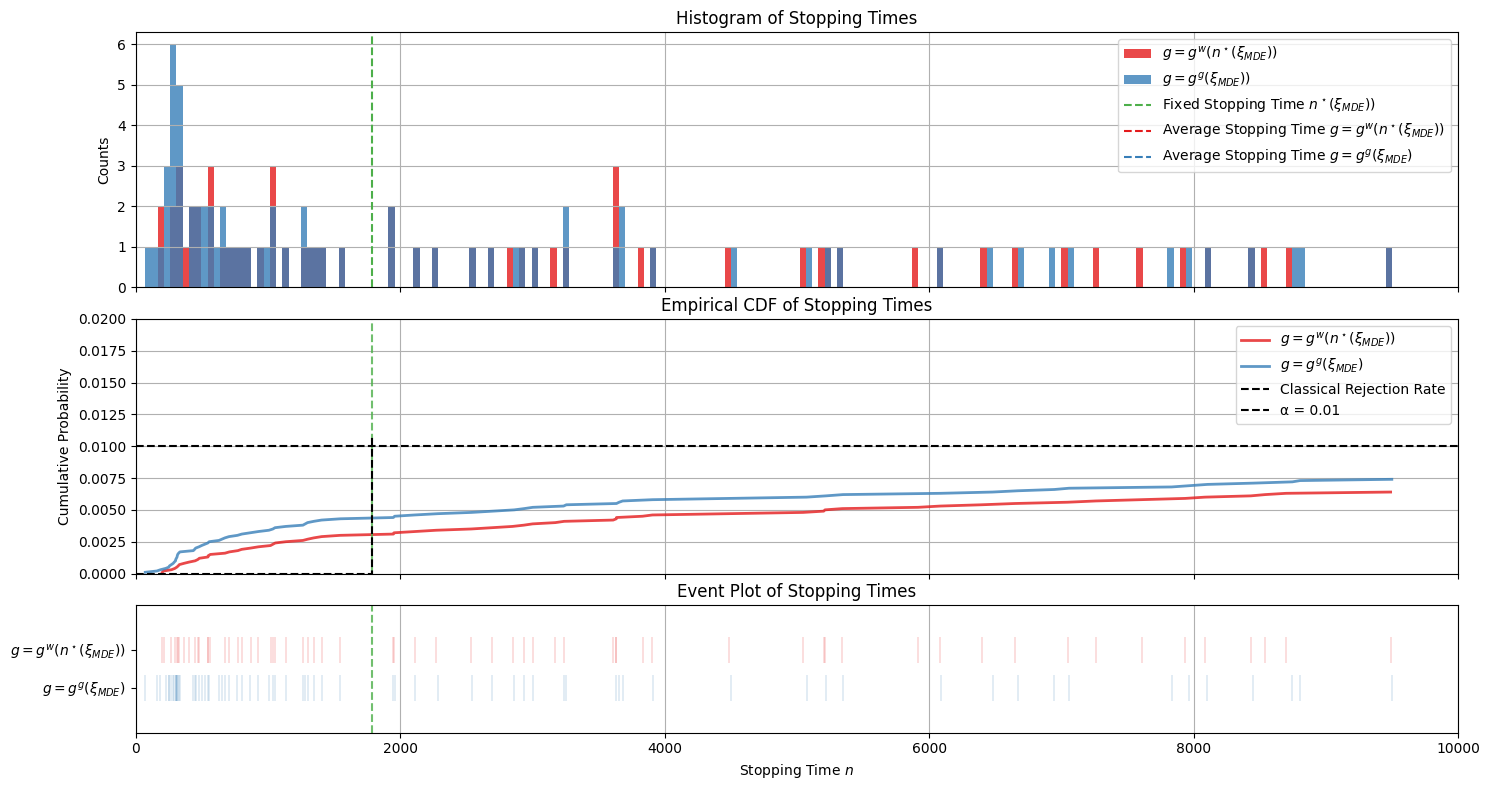

In [15]:
# Calculate optimal bins based on both datasets
all_data = np.concatenate([G_width_stopping_times, G_growth_stopping_times])
counts, bins = np.histogram([d for d in all_data if not np.isnan(d)], bins=200)

colors = plt.cm.get_cmap('Set1').colors
width_color = colors[0]  # Second color in Set1
growth_color = colors[1]  # Third color in Set1
fixed_color = colors[2]  # Fourth color in Set1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), height_ratios=[2, 2, 1], sharex=True)

# Top pane: Histogram
if delta_0 == 0.0:
    density = False
else:
    density = True
ax1.hist(G_width_stopping_times, bins=bins, alpha=0.8, label='$g = g^w(n^\\star(\\xi_{MDE}))$', density=density, color = width_color)
ax1.hist(G_growth_stopping_times, bins=bins, alpha=0.8, label='$g = g^g(\\xi_{MDE}))$', density=density, color = growth_color)
ax1.axvline(x=n_req,  linestyle='--', label='Fixed Stopping Time $n^\\star(\\xi_{MDE}))$', color=fixed_color)
ax1.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='Average Stopping Time $g = g^w(n^\\star(\\xi_{MDE}))$', color = width_color)
ax1.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='Average Stopping Time $g = g^g(\\xi_{MDE})$', color = growth_color)
ax1.grid()
ax1.legend()
if delta_0 == 0.0:
    ax1.set_ylabel('Counts')
else:
    ax1.set_ylabel('Density')
ax1.set_title('Histogram of Stopping Times')


ax2.plot(G_width_stopping_times, G_width_ecdf, alpha=0.8, linewidth=2, label='$g = g^w(n^\\star(\\xi_{MDE}))$', color=width_color)
ax2.plot(G_growth_stopping_times, G_growth_ecdf, alpha=0.8, linewidth=2, label='$g = g^g(\\xi_{MDE})$', color=growth_color)
ax2.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax2.axvline(x=np.mean(G_width_stopping_times), linestyle='--', alpha=0.8, color=width_color)
ax2.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', alpha=0.8, color=growth_color)
ax2.grid()
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Empirical CDF of Stopping Times')
ax2.step([0, n_req], [0, np.mean(classical_rejection)], where='post',
         linestyle='--', color='black', label='Classical Rejection Rate')
if delta_0 == 0.0:
    ax2.set_ylim(0,0.02)
    ax2.axhline(y=alpha, linestyle='--', color='black', label='α = 0.01')
    ax2.legend(loc='upper right')
else:
    ax2.set_ylim(0, 1)

# Bottom pane: Rugplot
ax3.eventplot(G_width_stopping_times, orientation='horizontal', lineoffsets=0.3, linelengths=0.4, 
              colors=width_color, alpha=1, linewidths=0.2)
ax3.eventplot(G_growth_stopping_times, orientation='horizontal', lineoffsets=-0.3, linelengths=0.4, 
              colors=growth_color, alpha=1, linewidths=0.2)
ax3.axvline(x=n_req, linestyle='--', alpha=0.8, color=fixed_color)
ax3.axvline(x=np.mean(G_width_stopping_times),  linestyle='--', label='$g = g^w(n^\\star(\\xi_{MDE}))$ mean', color = width_color)
ax3.axvline(x=np.mean(G_growth_stopping_times), linestyle='--', label='$g = g^g(\\xi_{MDE})$', color = growth_color)



# Clean up rugplot pane
ax3.set_ylim(-1, 1)
ax3.set_yticks([0.3, -0.3])
ax3.set_yticklabels(['$g = g^w(n^\\star(\\xi_{MDE}))$', '$g = g^g(\\xi_{MDE})$'])
ax3.set_title('Event Plot of Stopping Times')
ax3.set_xlabel('Stopping Time $n$')
ax3.grid(axis='x')

plt.xlim(0, n_total)
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)  # Small space between subplots
plt.savefig('stopping_times_xi_0.png', dpi=300, bbox_inches='tight')
plt.show()